<a href="https://colab.research.google.com/github/vladop22/PRA3024-Analysis-of-Big-Data-in-Physics/blob/main/GW_exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PART 1

In [27]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
#Firstly, we have to import the important libraries/packages for data analysis, visualization, and computing
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter,sigmasq
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate


In [30]:
d = np.load('/content/drive/MyDrive/noise_ts_4096Hz.npy') #loading a noise time series, first column contains the time values and the second contains noise values recorded by the detector.
dt = d[:, 0] # the time variable is extracted and stored in the variable dt
d = types.TimeSeries(d[:, 1], delta_t = dt[1]- dt[0]) # then we convert the noise into GW time series, with time value as the sample time and the 
# time step as the difference between the n and n-1 time values.
data = d # saving GW time series as a 'data' variable

(1e-47, 1e-42)

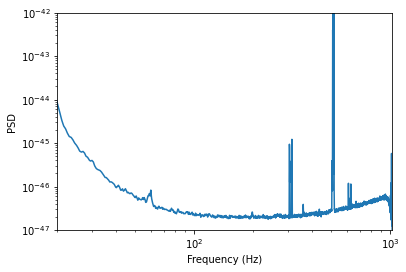

In [31]:
strain=resample_to_delta_t(highpass(data, 15.0), 1.0/2048).crop(4,4) # we apply the high pass filter (15 Hz cutoff) and downsample the data
# to 2048 Hz; crop removes the first and last 4 seconds of the measurement

stilde=strain.to_frequencyseries() # FT of the data/ converting to frequency series since 'stilde' contains the the amplitude and the phase
#of the different frequency components that can be further analysed.

# Calculates the power spectral density using the Welch method
# This method divides the time series data into smaller 'bins' that are overlapping and applies a window function to each of the segments to reduce
# spectral leakage. The segments undergo FT and psd is estimated from there. 
delta_t = strain.delta_t
seg_len = int(2 / delta_t) # length of each segment
seg_stride = int(seg_len / 2) # overlap between segments
psd  = pycbc.psd.welch(strain,
                  seg_len=seg_len,
                  seg_stride=seg_stride)

psd = interpolate(psd, stilde.delta_f) # contains the frequency values and the psd values at those frequencies


#plotting
pylab.loglog(psd.sample_frequencies, psd);
pylab.xlabel('Frequency (Hz)');
pylab.ylabel('PSD');
pylab.xlim(20, 1024);
pylab.ylim(1e-47, 1e-42)

Text(0.5, 0, 'mass')

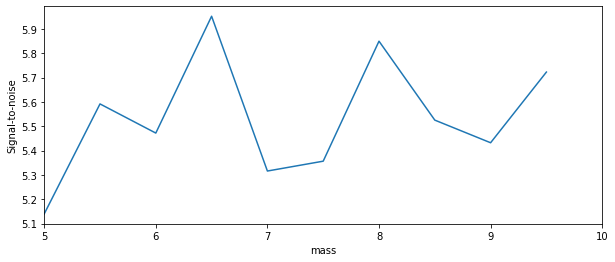

In [32]:
mass_range = np.arange(5, 10,0.5 ) # calculating snr over a smaller range/computing time is lower
Snr_list = []
for m in mass_range:
  hp, hc = get_td_waveform(approximant="TaylorT2", # generating the waveform under the assumption that m_1 = m_2
                     mass1=m,
                     mass2=m,
                     delta_t=strain.delta_t,
                     f_lower=15.0) #cutoff frequency

  hp.resize(len(strain)) # waveform is being resized to the length of the strain to ensure they can be used for further analysis


  template = hp.cyclic_time_shift(hp.start_time) # cyclic time shift performed on the waveform created
  # end of the waveform is wrapped around the beginning of the waveform. Particularly useful for matching waveforms that have the same periodicity,
  # but do not start at the same time.

  snr = matched_filter(template, strain, # snr generation through matched filter
                    psd=psd, low_frequency_cutoff=15.0)
  snr_H1 = snr.crop(4 + 4, 4) # final snr is cropped (4 seconds from the beginning and from the end)

  Snr_list.append(max(abs(snr_H1))) # appending the final snr to the list


pylab.figure(figsize=[10, 4]) # plotting the snr vs mass to check whether there are any signals crossing 8, since we use it as a cutoff value.
pylab.plot(mass_range,Snr_list)
pylab.xlim(xmin = 5, xmax = 10);
pylab.ylabel('Signal-to-noise')
pylab.xlabel('mass')

From the graph above, we can see that no snr value crosses 8. Therefore, there is no GW signal in our data.

PART 2

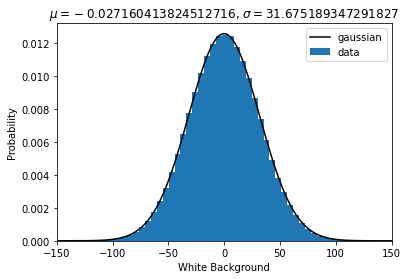

In [33]:
import scipy
from scipy.stats import norm


white_data = (strain.to_frequencyseries()/psd**0.5).to_timeseries() # whitening the data
white_data = white_data.crop(4,4) # cropping the data


boundaries = (-150,150) # x-axis limits of the histogram

mean,sd=norm.fit(white_data) # normal distribution data-fitting

x=np.linspace(*boundaries,300)
gauss=norm.pdf(x,mean,sd) # gaussian distribution defined by mean and standard deviation.


pylab.plot(x,gauss,'k',label='gaussian'); # plotting the distribution
y=pylab.hist(white_data,bins=100,density=True,label='data')
pylab.xlim(*boundaries);
pylab.legend();
pylab.title("$\mu={}$, $\sigma={}$".format(mean,sd));
pylab.xlabel("White Background");
pylab.ylabel("Probability");


The expected mean of the distribution is 0. The obtained value is slightly lower, but within the statistical significance of the problem.

PART 3

In [37]:
# Now, we are going to divide data into a number of segments
n = 40 #number of segments
d = white_data.duration/n #duration of each segment defined
t_i = white_data.start_time
t_f = t_i
segments = []

while(t_f != white_data.end_time):
  t_f+=d
  segments.append(white_data.time_slice(t_i,t_f))
  t_i=t_f

  
SNRS=[] # Then, we are going to calculate the power spectral density and snr for each segment
for st in segments:
  st_tilde=strain.to_frequencyseries()
  delta_t = st.delta_t
  seg_len = int(2 / delta_t)
  seg_stride = int(seg_len / 2) 
  psd  = pycbc.psd.welch(st,
                    seg_len=seg_len,
                    seg_stride=seg_stride) # calculating the psd using the Welch method

  psd = interpolate(psd, st_tilde.delta_f)

  hp,hc= get_fd_waveform(approximant="TaylorF2", #generating the waveform under the assumption that m_1 = m_2 = 3
                     mass1=3,
                     mass2=3,
                     delta_f=st_tilde.delta_f,
                     f_lower=15.0) # cutoff frequency
  hp.resize(len(st_tilde))


  SNR=(sigmasq(hp,psd))**0.5 # calculatin the snr and then appending it to snrs list
  
  SNRS.append(SNR)

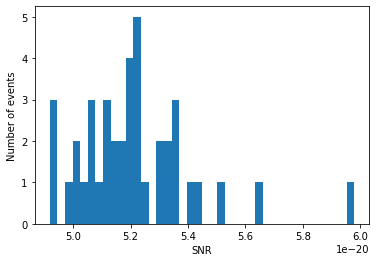

In [36]:
# plotting the histogram
pylab.hist(SNRS,bins = n, density = False);
pylab.xlabel('SNR');
pylab.ylabel('Number of events');

From the histogram above, we can confirm that the background is not stationary. However, most of the observed events are concentrated around a smaller range of snr values, and therefore, it is reasonable to assume a constant bacground in order to ease the analysis of the GW.